# 캐글커널 필사

출처: https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sb

# tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import os
for file in os.listdir('./word2vec-nlp-tutorial/'):
    print(file)

Using TensorFlow backend.


labeledTrainData.tsv
sampleSubmission.csv
testData.tsv
unlabeledTrainData.tsv


In [2]:
SMALL_SIZE=12
MEDIUM_SIZE =14
BIG_SIZE=16
LARGE_SIZE=20

params={
    'figure.figsize': (16,8),
    'font.size':SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize':MEDIUM_SIZE,
    'axes.labelsize':BIG_SIZE
}
plt.rcParams.update(params)

### additional_data 수정 (reference from: 김성한님)

 
 -원본 컬럼: unnamed:0, type, review, label, file
 
 -수정 컬럼: review, sentiment

In [37]:
imdb_master=pd.read_csv('./word2vec-nlp-tutorial/imdb-review-dataset/imdb_master.csv',
                        encoding='ISO-8859-1')
imdb_master.head(3)

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt


In [38]:
imdb_master.shape

(100000, 5)

In [39]:
imdb_master_filtered=imdb_master[['review', 'label']] #컬럼 reveiw, label만 추출

In [8]:
imdb_master_filtered['label'].value_counts()

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64

In [10]:
# 관측되지 않은 데이터 (unsup) 제거
imdb_master_filtered= imdb_master_filtered[imdb_master_filtered['label']!='unsup']
imdb_master_filtered.head(3)

,review,label
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg


In [12]:
# sentiment column 만들기
def label_to_sentiment(x):
    if x=='neg':
        return 0
    else:
        return 1
    
imdb_master_filtered['sentiment']=imdb_master_filtered['label'].apply(label_to_sentiment)
imdb_master_filtered.head()

,review,label,sentiment
0,Once again Mr. Costner has dragged out a movie...,neg,0
1,This is an example of why the majority of acti...,neg,0
2,"First of all I hate those moronic rappers, who...",neg,0
3,Not even the Beatles could write songs everyon...,neg,0
4,Brass pictures (movies is not a fitting word f...,neg,0


In [13]:
#확인하기
check_pos=imdb_master_filtered.loc[imdb_master_filtered['label']=='pos', ['label', 'sentiment']]
check_neg=imdb_master_filtered.loc[imdb_master_filtered['label']=='neg', ['label', 'sentiment']]

In [14]:
check_pos['sentiment'].value_counts()

1    25000
Name: sentiment, dtype: int64

In [15]:
check_neg['sentiment'].value_counts()

0    25000
Name: sentiment, dtype: int64

In [17]:
# label 컬럼 제거
imdb_master_filtered.drop(columns=['label'], axis=1, inplace=True)
imdb_master_filtered.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [42]:
imdb_master_filtered['review'][1]

"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...<br /><br />Overall, this is second-rate action trash. There are countless better films to see, and if you really want to s

In [26]:
#저장
imdb_master_filtered.to_csv('./word2vec-nlp-tutorial/imdb_master_filtered.csv')

In [43]:
usecols=['review', 'sentiment']

train_data= pd.read_csv('./word2vec-nlp-tutorial/labeledTrainData.tsv',
                        usecols=usecols,
                        sep='\t')

additional_data= pd.read_csv('./word2vec-nlp-tutorial/imdb_master_filtered.csv')[usecols]

unlabeled_data=pd.read_csv('./word2vec-nlp-tutorial/unlabeledTrainData.tsv', 
                            error_bad_lines=False,
                            sep='\t')

submission_data = pd.read_csv('./word2vec-nlp-tutorial/testData.tsv', 
                              sep='\t')

b'Skipping line 43043: expected 2 fields, saw 3\n'


In [44]:
datasets=[train_data, additional_data, submission_data, submission_data, unlabeled_data]

titles= ['Train data', 'Additional data', 'Unlabeled train data', 'Submission data']
for dataset, title in zip(datasets, titles):
    print(title)
    dataset.info()
    display(dataset.head())

Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


Additional data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null int64
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


Unlabeled train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.8+ KB


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


Submission data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.8+ KB


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [45]:
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate( (all_reviews, dataset.review), axis=0)
print('Total number of reviews: ', len(all_reviews))

Total number of reviews:  174998


In [46]:
train_data= pd.concat((train_data, additional_data[additional_data.sentiment != -1]),
                     axis=0, ignore_index=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
review       75000 non-null object
sentiment    75000 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


# Check class balance

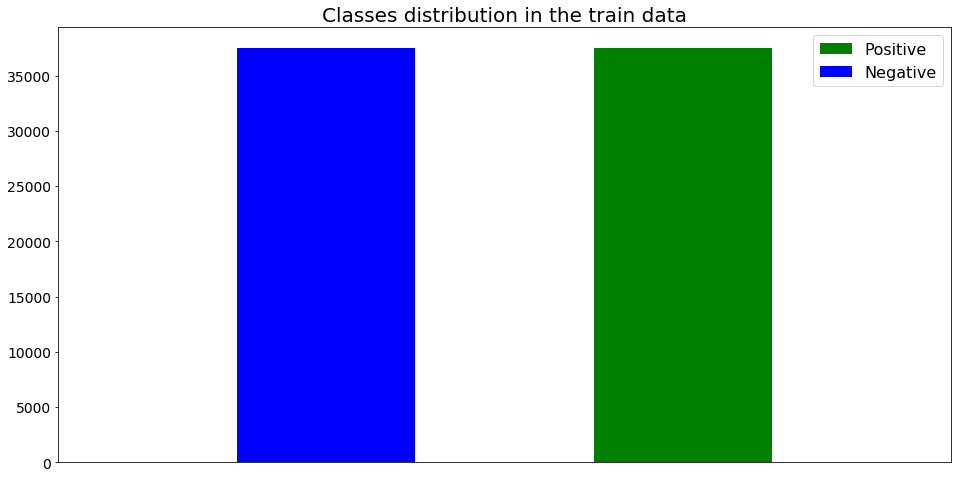

In [47]:
plt.hist(train_data[train_data.sentiment==1].sentiment,
        bins=2, color='green', label='Positive')

plt.hist(train_data[train_data.sentiment==0].sentiment,
        bins=2, color='blue', label='Negative')

plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [63]:
def clean_review(raw_review: str)->str:
    # 01. remove html
    review_text= BeautifulSoup(raw_review, 'lxml').get_text()
    
    # 02. remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(' ', review_text)
    
    # 03. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters

def lemmatize(tokens: list)->list:
    # 01. Lemmatize
    tokens= list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens= list(map(lambda x:lemmatizer.lemmatize(x,'v'), tokens))
    
    #02. remove stop words
    meaningful_words= list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words

def preprocess(review: str, total: int, show_progress: bool=True)->list:
    if show_progress:
        global counter
        counter+=1
        print('Processing.. %6i/%6i' %(counter, total), end='\r')
        
    #01. clean text
    review= clean_review(review)
    
    #02. split into individual words
    tokens= word_tokenize(review)
    
    #03. Lemmatize
    lemmas= lemmatize(tokens)
    
    #04. join the words back into one string seperated by space and return the results
    return lemmas

In [64]:
counter=0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

In [65]:
all_reviews= np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter=0

In [68]:
X_train_data= all_reviews[: train_data.shape[0]]
Y_train_data= train_data.sentiment.values
X_submission = all_reviews[125000:150000]

In [71]:
train_data['review_length']=np.array(list(map(len,X_train_data)))
median= train_data['review_length'].median()
mean= train_data['review_length'].mean()
mode= train_data['review_length'].mode()[0]

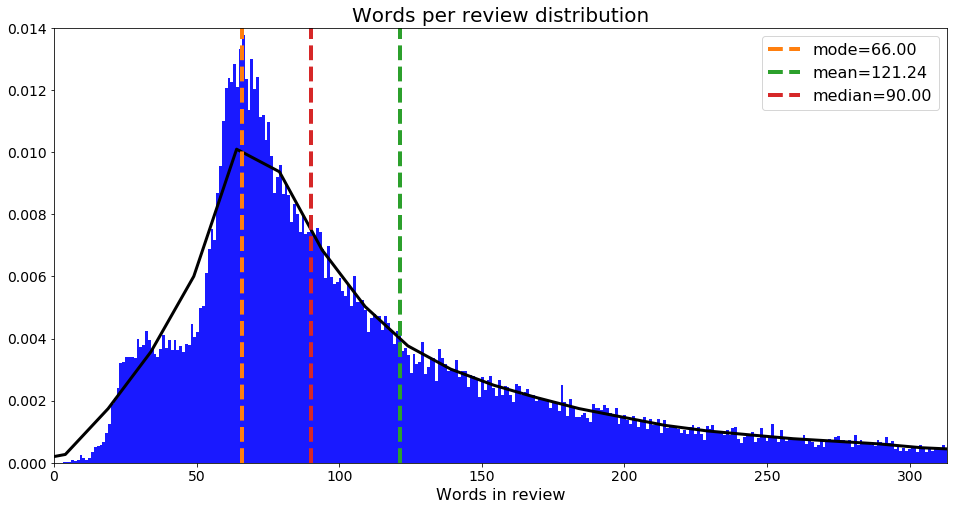

In [72]:
fig, ax= plt.subplots()
sb.distplot(train_data['review_length'],
            bins=train_data['review_length'].max(),
            hist_kws={'alpha':0.9, 'color':'blue'}, ax=ax,
            kde_kws={'color':'black', 'linewidth':3})

ax.set_xlim(left=0, right=np.percentile(train_data['review_length'], 95))
ax.set_xlabel('Words in review')
ymax=0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0,ymax], '--', label=f'mode={mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0,ymax], '--', label=f'mean={mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--', label=f'median={median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

In [73]:
%%time
bigrams=Phrases(sentences=all_reviews)

Wall time: 1min 5s


In [74]:
%%time
trigrams = Phrases(sentences=bigrams[all_reviews])

Wall time: 3min 33s


In [75]:
# we can use gensim's phrases to find bigrams or trigrams
print(bigrams['space station near the solar system'.split()])

['space_station', 'near', 'the', 'solar_system']


In [76]:
%%time
embedding_vector_size=256
trigrams_model= Word2Vec(
    sentences= trigrams[bigrams[all_reviews]],
    size=embedding_vector_size,
    min_count=3, window=5, workers=4
)

Wall time: 32min 58s


In [77]:
print('Vocabulary size: ', len(trigrams_model.wv.vocab))

Vocabulary size:  140067


In [78]:
trigrams_model.wv.most_similar('galaxy')

[('planet', 0.7380872964859009),
 ('space_station', 0.7016164660453796),
 ('spacecraft', 0.6951215267181396),
 ('continent', 0.6727888584136963),
 ('portal', 0.6713751554489136),
 ('starship', 0.6706010103225708),
 ('wormhole', 0.6645321846008301),
 ('seal', 0.6570920944213867),
 ('deep_space', 0.6483907699584961),
 ('asteroid', 0.6450989246368408)]

In [79]:
trigrams_model.wv.doesnt_match(['galaxy', 'starship', 'planet', 'dog'])

'dog'

In [80]:
%%time
def vectorize_data(data, vocab:dict)->list:
    print('Vectorize sentences...', end='\r')
    keys=list(vocab.keys())
    filter_unknown= lambda word: vocab.get(word, None) is not None
    encode=lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized=list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams....', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams.... (done)')

input_length=150
X_pad= pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post'
)
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams.... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
Wall time: 32min 44s


In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.05,
    shuffle=True,
    random_state=42)

In [82]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model= Sequential()
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        input_length=input_length,
        weights=[embedding_matrix],
        trainable=False))
    
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model=build_model(embedding_matrix= trigrams_model.wv.vectors,
                 input_length=input_length)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 256)          35857152  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 36,267,905
Trainable params: 410,753
Non-trainable params: 35,857,152
___

In [84]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

history=model.fit(
    x=X_train,
    y=y_train,
    validation_data= (X_test, y_test),
    batch_size=100,
    epochs=20
)

Instructions for updating:
Use tf.cast instead.
Train on 71250 samples, validate on 3750 samples
Epoch 1/20
71250/71250 [==============================] - 1750s 25ms/step - loss: 0.5169 - acc: 0.7435 - val_loss: 0.4484 - val_acc: 0.7901
Epoch 2/20
71250/71250 [==============================] - 1746s 25ms/step - loss: 0.3589 - acc: 0.8434 - val_loss: 0.3247 - val_acc: 0.8600
Epoch 3/20
71250/71250 [==============================] - 1859s 26ms/step - loss: 0.2815 - acc: 0.8831 - val_loss: 0.2944 - val_acc: 0.8813
Epoch 4/20
71250/71250 [==============================] - 1794s 25ms/step - loss: 0.2123 - acc: 0.9160 - val_loss: 0.2468 - val_acc: 0.9035
Epoch 5/20
71250/71250 [==============================] - 3006s 42ms/step - loss: 0.1522 - acc: 0.9417 - val_loss: 0.2382 - val_acc: 0.9157
Epoch 6/20
71250/71250 [==============================] - 6368s 89ms/step - loss: 0.1120 - acc: 0.9582 - val_loss: 0.2313 - val_acc: 0.9248
Epoch 7/20
71250/71250 [==============================] - 2839s

In [89]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None, 
                          normed=True, title='Confusion matrix'):
    matrix=confusion_matrix(y_true, y_pred)
    if normed:
        matrix= matrix.astype('float')/ matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [86]:
%%time
y_train_pred= model.predict_classes(X_train)
y_test_pred= model.predict_classes(X_test)

Wall time: 9min 25s


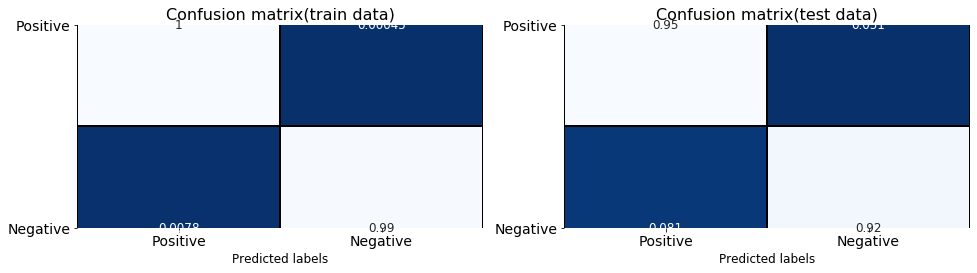

In [90]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                     title='Confusion matrix(train data)',
                     class_names=['Positive', 'Negative'])

plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                     title='Confusion matrix(test data)',
                     class_names=['Positive', 'Negative'])


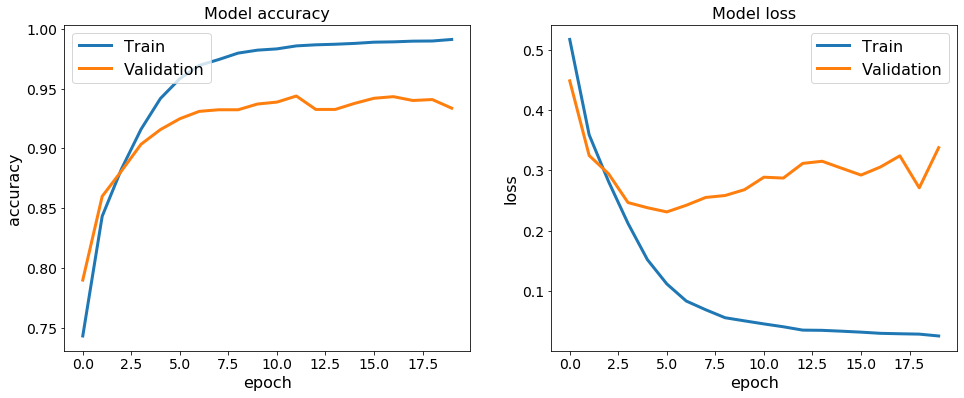

In [91]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# Summarize history for accuracy
axis1.plot(history.history['acc'], label='Train', linewidth=3)
axis1.plot(history.history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')


# Summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)

axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

# Make Submission

In [92]:
print('Convert sentences to sentences with ngrams....', end='\r')
X_submit= trigrams[bigrams[X_submission]]

print('Convert sentences to sentences with ngrams....(done)')
X_sub= pad_sequences(
    sequences=vectorize_data(X_submit, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')

print('Transform sentences to sequences...(done)')

Convert sentences to sentences with ngrams....(done)
Vectorize sentences... (done)
Transform sentences to sequences...(done)


In [ ]:
%%time
Y_sub_pred= model.predict_classes(X_sub)

In [ ]:
def submit(predictions):
    submission_data['sentiment']=predictions
    submission_data.to_csv('submission.csv', index=False, 
                           columns=['id', 'sentiment'])
submit(Y_sub_pred)